In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Maximum, MaxPooling3D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Input

import numpy as np
import operator
import pandas as pd

from util.common import to_rgb_img, to_categorical
from util.ccp import CCP_COLOR_MAP
from util.io import open_images

In [3]:
DATASET_X_PATH = '/home/danfergo/SIG/Code/Experiments/data/ccp/x'
DATASET_Y_PATH = '/home/danfergo/SIG/Code/Experiments/data/ccp/y'
I_SIZE = 150

In [ ]:
import os
import numpy as np 

from util.io import open_images 
from util.common import to_categorical

import imp  
import util.io
imp.reload(util.io)  

train_x = np.array(open_images(DATASET_X_PATH + '/train', n=3))

train_y = open_images(DATASET_Y_PATH + '/train', expand_dims=False, n=3)
train_y = np.array(to_categorical(train_y))

validation_x = np.array(open_images(DATASET_X_PATH + '/validation', n=3))

validation_y = open_images(DATASET_Y_PATH + '/validation', expand_dims=False, n=3)
validation_y = np.array(to_categorical(validation_y))

np.save(DATASET_X_PATH + '/train_x.npy', train_x)
np.save(DATASET_Y_PATH + '/train_y.npy', train_y)
np.save(DATASET_X_PATH + '/validation_x.npy', validation_x)
np.save(DATASET_Y_PATH + '/validation_y.npy', validation_y)

In [4]:
import numpy as np 

train_x = np.load(DATASET_X_PATH + '/train_x.npy')
train_y = np.load(DATASET_Y_PATH + '/train_y.npy')
validation_x = np.load(DATASET_X_PATH + '/validation_x.npy')
validation_y = np.load(DATASET_Y_PATH + '/validation_y.npy')

(3, 200, 200, 3)
(3, 200, 200, 58)
(3, 200, 200, 3)
(3, 200, 200, 58)


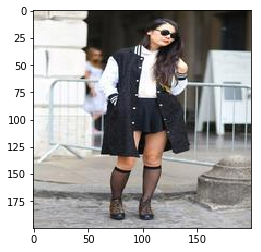

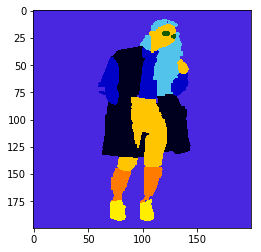

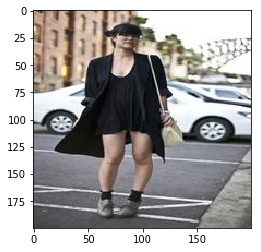

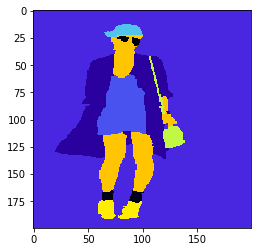

In [5]:
import imp  
import util.common
imp.reload(util.common)  

print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

plt.imshow(np.uint8(train_x[0]))
plt.show()

plt.imshow(np.uint8(util.common.to_rgb_img(train_y[0], CCP_COLOR_MAP, argmax=True)))
plt.show()

plt.imshow(np.uint8(validation_x[0]))
plt.show()

plt.imshow(np.uint8(util.common.to_rgb_img(validation_y[0], CCP_COLOR_MAP, argmax=True)))
plt.show()

In [76]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Activation, Conv2DTranspose, Lambda, UpSampling2D
from keras import regularizers
from keras.models import Sequential
from keras import backend as K
import tensorflow as tf 

from keras.applications.resnet50 import ResNet50

resNet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(200, 200, 3))


model = Sequential()
# padding='same', 

model.add(resNet50)

def deconv_block(model, size, n_filters): 
    #model = Sequential()
    for i in range(size):
        model.add(Conv2DTranspose(n_filters, (1,1), kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
        n_4 = 4 * n_filters
        model.add(Conv2DTranspose(n_4, (1,1), kernel_regularizer=regularizers.l2(0.01), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

#model.add(UpSampling2D(size=(2, 2)))
#for i in range(3):
#    model.add(Conv2DTranspose(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
#    model.add(Activation('relu'))
#    model.add(BatchNormalization())
         
deconv_block(model, 3, 512)
#model.add(UpSampling2D(size=(2, 2)))
deconv_block(model, 6, 256)
model.add(UpSampling2D(size=(2, 2)))
deconv_block(model, 4, 128)
model.add(UpSampling2D(size=(2, 2)))

deconv_block(model, 3, 64)

model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2DTranspose(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))

#model.add(UpSampling2D(size=(3, 3), strides=2))
#deconv_block(model, 1, 64, (7,7), False)



model.add(Conv2DTranspose(58, (3,3), kernel_regularizer=regularizers.l2(0.01)))

          
def depth_softmax(matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    softmax_matrix = sigmoided_matrix / tf.reduce_sum(sigmoided_matrix, axis=3, keep_dims=True)
    return softmax_matrix

model.add(Lambda(depth_softmax))

In [77]:
#from keras.utils import plot_model
#from IPython.display import Image

#plot_model(model, to_file='model.png', show_shapes=True)
#Image(filename='model.png')

In [78]:
HISTORY_PATH = '/home/danfergo/SIG/Code/Experiments/history/experiment_3.10'
#model.load_weights(HISTORY_PATH + '_weights.pkl')
model.compile(loss='categorical_crossentropy',  optimizer='adadelta', metrics=[])

In [80]:
history = model.fit(
        train_x, train_y,
        epochs=10,
        batch_size=1,
        validation_data=(validation_x,validation_y)
        )
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch=24,
#        epochs=20,
#        validation_data=validation_generator,
#        validation_steps=6,
#        verbose=1)

Train on 3 samples, validate on 3 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1,64,198,198]
	 [[Node: conv2d_transpose_995/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](conv2d_transpose_995/stack, conv2d_transpose_995/kernel/read, up_sampling2d_48/ResizeNearestNeighbor)]]
	 [[Node: add_947/_26479 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_77692_add_947", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_transpose_995/conv2d_transpose', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/danfergo/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/danfergo/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/danfergo/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/danfergo/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/danfergo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/danfergo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/danfergo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/danfergo/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/danfergo/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/danfergo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/danfergo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/danfergo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-76-109b4f16bc6a>", line 50, in <module>
    model.add(Conv2DTranspose(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
  File "/usr/local/lib/python3.5/dist-packages/keras/models.py", line 455, in add
    output_tensor = layer(self.outputs[0])
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 545, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/convolutional.py", line 771, in call
    data_format=self.data_format)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 2901, in conv2d_transpose
    padding=padding)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 1104, in conv2d_transpose
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 496, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,64,198,198]
	 [[Node: conv2d_transpose_995/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](conv2d_transpose_995/stack, conv2d_transpose_995/kernel/read, up_sampling2d_48/ResizeNearestNeighbor)]]
	 [[Node: add_947/_26479 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_77692_add_947", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
# save weights
HISTORY_PATH = '/home/danfergo/SIG/Code/Experiments/history/experiment_3.2'
model.save_weights(HISTORY_PATH + '_weights.pkl')

In [ ]:
# (re)save and load history
import pickle

past_history = {}

try:
    pkl_file = open(HISTORY_PATH + '_history.pkl', 'rb')
    past_history = pickle.load(pkl_file)
    pkl_file.close()
except:
    pass

full_history = {}

for k in history.history:
    if k in past_history:
        full_history[k] = np.concatenate((past_history[k], history.history[k]), axis=0)
    else:
        full_history[k] = history.history[k]

pkl_file = open(HISTORY_PATH + '_history.pkl', 'wb')
pickle.dump(full_history, pkl_file)
pkl_file.close()

# summarize history for loss
plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# summarize history for loss, second half
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Test

In [ ]:
# x_test, y_test = validation_generator.next()
# import pickle 
# x_test, y_test = (train_x, train_y)
x_test, y_test = (validation_x, validation_y)
y_pred = model.predict(x_test, batch_size=10)

In [ ]:
np.save('predictions.npy', y_pred)

In [ ]:
from util.common import to_rgb_img, to_categorical

for i in range(0,len(y_pred)):
    plt.imshow(np.uint8(x_test[i]))
    plt.show()

    plt.imshow(np.uint8(to_rgb_img(y_test[i], CCP_COLOR_MAP, argmax=True)))
    plt.show()

    plt.imshow(np.uint8(to_rgb_img(y_pred[i], CCP_COLOR_MAP, argmax=True)))
    plt.show()